In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import warnings

warnings.filterwarnings("ignore")


# True model: y = a*x^2 + b*x + c + noise
def generate_data(a, b, c, x, noise_std):
    return a * x**2 + b * x + c + np.random.normal(0, noise_std, size=len(x))

def log_prior(a, b, c):
    if -5 <= a <= 5 and -5 <= b <= 5 and -5 <= c <= 5:
        return 0.0  # Uniform prior
    return -np.inf

def log_likelihood(x, y, a, b, c, noise_std):
    y_model = a * x**2 + b * x + c
    return -0.5 * np.sum(((y - y_model) / noise_std)**2)

def log_probability(theta, x, y_list, noise_std):
    a, b, c = theta
    lp = log_prior(a, b, c)
    if not np.isfinite(lp):
        return -np.inf
    return lp + sum(log_likelihood(x, y_obs, a, b, c, noise_std) for y_obs in y_list)


In [2]:
# Ground truth parameters
a_true, b_true, c_true = 1.0, -1.0, 1.0
noise_std = 1.0

# Observation grid and data
N = 50
N_events = 10
x_grid = np.linspace(0, 1, N)
y_obs_list = [generate_data(a_true, b_true, c_true, x_grid, noise_std) for _ in range(N_events)]


100%|██████████| 1000/1000 [00:04<00:00, 222.60it/s]


emcee samples shape: (28800, 3)


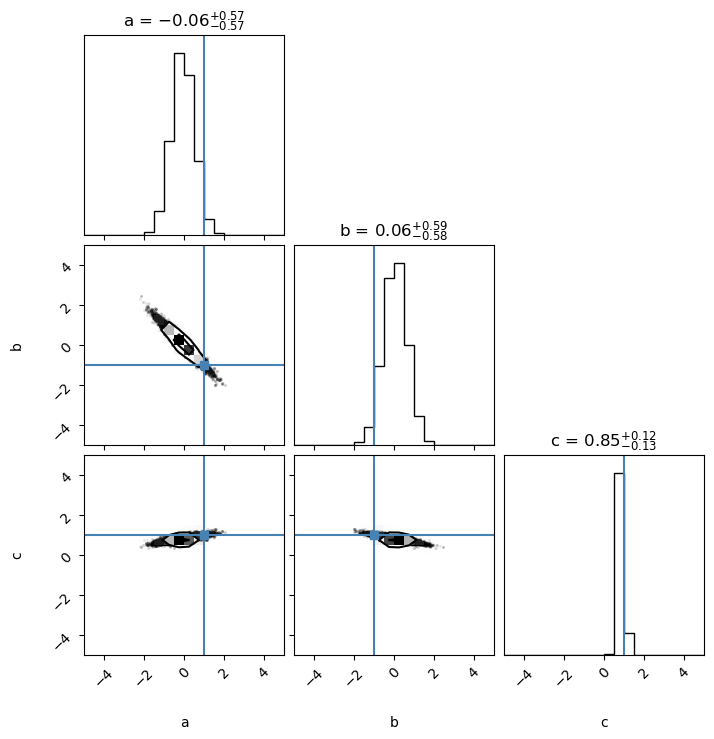

In [3]:
ndim = 3
nwalkers = 32
nsteps = 1000
p0 = np.random.uniform(-5, 5, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_grid, y_obs_list, noise_std))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples_emcee = sampler.get_chain(discard=100, flat=True)
print("emcee samples shape:", samples_emcee.shape)

fig = corner.corner(
    samples_emcee,
    labels=["a", "b", "c"],
    truths=[a_true, b_true, c_true],
    range=[(-5, 5), (-5, 5), (-5, 5)],
    show_titles=True
)
plt.show()


In [7]:
from HiFlowPE.priors_likelihoods import GaussianLikelihood
from HiFlowPE.HierarchicalFlowPE import HierarchicalFlowTrainer

class ParabolaGaussianLikelihood(GaussianLikelihood):
    def __init__(self, x, y_obs, noise_std):
        self.x = x
        self.y_obs = y_obs
        self.noise_std = noise_std

    def log_likelihood(self, params):
        a, b, c = params["a"], params["b"], params["c"]
        y_model = a * self.x**2 + b * self.x + c
        residuals = (self.y_obs - y_model) / self.noise_std
        return -0.5 * np.sum(residuals**2)


from HiFlowPE.priors_likelihoods import UniformPrior

# Define the uniform prior over a, b, c
prior = UniformPrior({"a": (-5, 5), "b": (-5, 5), "c": (-5, 5)})

# One likelihood per observed event
likelihoods = [
    ParabolaGaussianLikelihood(x_grid, y_obs, noise_std)
    for y_obs in y_obs_list
]


In [16]:
from glasflow.flows import RealNVP
from HiFlowPE.HierarchicalFlowPE import HierarchicalFlowTrainer
import torch

flow = RealNVP(
    n_inputs=3,
    n_transforms=2,
    n_neurons=32,
    n_blocks_per_transform=2,
    batch_norm_within_blocks=True,
    batch_norm_between_transforms=True,
    linear_transform='lu'
).to("cuda")

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
trainer = HierarchicalFlowTrainer(flow, prior, likelihoods, device="cuda")

losses = trainer.train(
    n_epochs=100,
    n_samples_per_epoch=2000,
    optimizer=optimizer
)


[Epoch 1/100] Loss: 0.003856
[Epoch 2/100] Loss: 0.003632
[Epoch 3/100] Loss: 0.003561
[Epoch 4/100] Loss: 0.003482
[Epoch 5/100] Loss: 0.003293
[Epoch 6/100] Loss: 0.003247
[Epoch 7/100] Loss: 0.003091
[Epoch 8/100] Loss: 0.003053
[Epoch 9/100] Loss: 0.003089
[Epoch 10/100] Loss: 0.002948
[Epoch 11/100] Loss: 0.002900
[Epoch 12/100] Loss: 0.002689
[Epoch 13/100] Loss: 0.003056
[Epoch 14/100] Loss: 0.002863
[Epoch 15/100] Loss: 0.002862
[Epoch 16/100] Loss: 0.002831
[Epoch 17/100] Loss: 0.002781
[Epoch 18/100] Loss: 0.002449
[Epoch 19/100] Loss: 0.002604
[Epoch 20/100] Loss: 0.002600
[Epoch 21/100] Loss: 0.002379
[Epoch 22/100] Loss: 0.003059
[Epoch 23/100] Loss: 0.002394
[Epoch 24/100] Loss: 0.002662
[Epoch 25/100] Loss: 0.002418
[Epoch 26/100] Loss: 0.002238
[Epoch 27/100] Loss: 0.002558
[Epoch 28/100] Loss: 0.002675
[Epoch 29/100] Loss: 0.002349
[Epoch 30/100] Loss: 0.002343
[Epoch 31/100] Loss: 0.002394
[Epoch 32/100] Loss: 0.002240
[Epoch 33/100] Loss: 0.002666
[Epoch 34/100] Loss

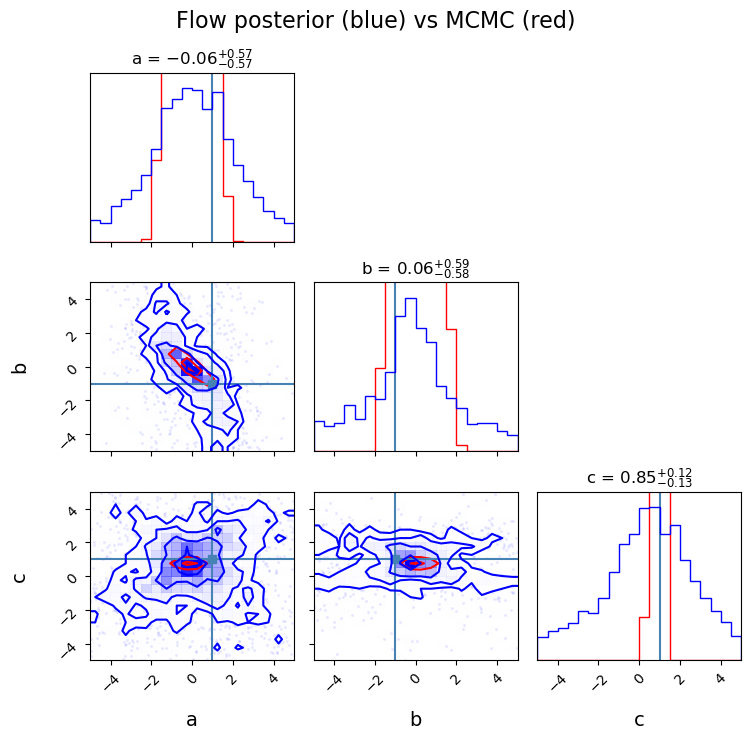

In [17]:

# --- Sample from trained flow ---
flow.eval()
with torch.no_grad():
    samples_flow = flow.sample(5000).cpu().numpy()

# --- Compare to emcee ---
import corner

figure = corner.corner(samples_emcee, 
                       labels=["a", "b", "c"], 
                       truths=[a_true, b_true, c_true], 
                       color='red',
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       label_kwargs={"fontsize": 14},
                       range=[(-5, 5), (-5, 5), (-5, 5)])

corner.corner(samples_flow, 
              fig=figure, 
              color='blue',
            labels=["a", "b", "c"], range=[(-5, 5), (-5, 5), (-5, 5)])

plt.suptitle("Flow posterior (blue) vs MCMC (red)", fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
samples_flow.shape  # should be (N_samples, 3)


(5000, 3)